In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import mediapipe as mp
import cv2


In [20]:
import gc
torch.cuda.empty_cache()
gc.collect()


19

In [21]:
class EfficientNetB0ISLClassifier:
    def __init__(self, data_dir, device=None):
        self.data_dir = data_dir
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = 8
        self.num_workers = 4

        # Load default pretrained weights and transforms
        self.weights = EfficientNet_B0_Weights.DEFAULT
        self.transforms = self.weights.transforms()

        # Apply transforms
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            self.transforms
        ])
        self.val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            self.transforms
        ])

        # Load data
        self.setup_datasets()
        self.model = self.create_model()
        self.best_acc = 0.0
        self.class_names = self.train_dataset.classes

        print(f"✅ EfficientNet-B0 initialized on {self.device}")
        print(f"Classes: {len(self.class_names)}")
        print(f"Train: {len(self.train_dataset)} | Valid: {len(self.val_dataset)}")

    def setup_datasets(self):
        self.train_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, "train"), transform=self.train_transforms)
        self.val_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, "valid"), transform=self.val_transforms)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                                       num_workers=self.num_workers, pin_memory=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                                     num_workers=self.num_workers, pin_memory=True)

    def create_model(self):
        model = efficientnet_b0(weights=self.weights)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, len(self.train_dataset.classes))
        return model.to(self.device)

    def train(self, num_epochs=20, learning_rate=0.001, save_path="best_efficientnetb0_model.pth"):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        train_losses, train_accuracies, val_accuracies = [], [], []

        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()
            running_loss = 0.0
            correct = 0

            loop = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for inputs, labels in loop:
                try:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    preds = outputs.argmax(dim=1)
                    correct += torch.sum(preds == labels.data)

                    loop.set_postfix(loss=loss.item(), acc=correct.item() / len(self.train_dataset))
                except Exception as e:
                    print(f"❌ Error in training batch: {e}")
                    continue

            epoch_loss = running_loss / len(self.train_dataset)
            epoch_acc = correct.double() / len(self.train_dataset)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())

            # Validation
            self.model.eval()
            val_correct = 0
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    preds = outputs.argmax(dim=1)
                    val_correct += torch.sum(preds == labels.data)

            val_acc = val_correct.double() / len(self.val_dataset)
            val_accuracies.append(val_acc.item())
            scheduler.step()

            print(f"[{epoch+1}] Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f} | Time: {time.time() - start_time:.2f}s")

            if val_acc > self.best_acc:
                self.best_acc = val_acc
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'class_names': self.class_names
                }, save_path)
                print(f"🎯 New best model saved: {save_path}")

        self.plot_history(train_losses, train_accuracies, val_accuracies)

    def plot_history(self, losses, train_accs, val_accs):
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(losses, label="Train Loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label="Train Acc")
        plt.plot(val_accs, label="Val Acc")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig("training_history.png")
        plt.show()
        print("📊 Saved training plot as 'training_history.png'")

    def evaluate(self, model_path=None):
        if model_path:
            checkpoint = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(checkpoint["model_state_dict"])
            self.class_names = checkpoint["class_names"]

        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(self.val_loader, desc="Evaluating"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = np.mean(np.array(all_preds) == np.array(all_labels))
        print(f"\n📊 Validation Accuracy: {acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=self.class_names))
        self.plot_confusion_matrix(all_labels, all_preds)

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        plt.show()
        print("📊 Saved confusion matrix as 'confusion_matrix.png'")


# Optional utility to check corrupt images before training
def verify_images(folder):
    print(f"🔍 Checking for corrupt images in: {folder}")
    for root, _, files in os.walk(folder):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
            except Exception as e:
                print(f"❌ Corrupt image: {img_path} | Error: {e}")
                # os.remove(img_path)  # Uncomment if you want to delete bad files


📦 Make sure the following are installed:
pip install torch torchvision scikit-learn matplotlib seaborn tqdm
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Owner/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:07<00:00, 2.91MB/s]


✅ EfficientNet-B0 initialized on cuda
Classes: 30
Train: 4410 | Valid: 1260


Epoch 1/20: 100%|██████████| 552/552 [01:12<00:00,  7.58it/s, acc=0.43, loss=1.89]    


[1] Train Loss: 1.9979 | Train Acc: 0.4304 | Val Acc: 0.7841 | Time: 103.96s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 2/20: 100%|██████████| 552/552 [01:10<00:00,  7.77it/s, acc=0.686, loss=1.31]   


[2] Train Loss: 1.0865 | Train Acc: 0.6857 | Val Acc: 0.8524 | Time: 98.89s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 3/20: 100%|██████████| 552/552 [01:53<00:00,  4.88it/s, acc=0.743, loss=0.194]  


[3] Train Loss: 0.9168 | Train Acc: 0.7433 | Val Acc: 0.9381 | Time: 149.88s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 4/20: 100%|██████████| 552/552 [01:21<00:00,  6.73it/s, acc=0.754, loss=1.78]   


[4] Train Loss: 0.8487 | Train Acc: 0.7540 | Val Acc: 0.9611 | Time: 135.32s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 5/20: 100%|██████████| 552/552 [01:36<00:00,  5.73it/s, acc=0.767, loss=3.43]   


[5] Train Loss: 0.8062 | Train Acc: 0.7667 | Val Acc: 0.9595 | Time: 133.63s


Epoch 6/20: 100%|██████████| 552/552 [01:18<00:00,  7.06it/s, acc=0.784, loss=0.201]  


[6] Train Loss: 0.7539 | Train Acc: 0.7839 | Val Acc: 0.9698 | Time: 115.48s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 7/20: 100%|██████████| 552/552 [02:12<00:00,  4.16it/s, acc=0.779, loss=0.0454]  


[7] Train Loss: 0.7434 | Train Acc: 0.7789 | Val Acc: 0.9659 | Time: 178.66s


Epoch 8/20: 100%|██████████| 552/552 [02:06<00:00,  4.37it/s, acc=0.84, loss=0.131]   


[8] Train Loss: 0.5519 | Train Acc: 0.8397 | Val Acc: 0.9817 | Time: 175.75s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 9/20: 100%|██████████| 552/552 [02:00<00:00,  4.57it/s, acc=0.839, loss=0.236]  


[9] Train Loss: 0.5450 | Train Acc: 0.8392 | Val Acc: 0.9841 | Time: 167.02s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 10/20: 100%|██████████| 552/552 [02:01<00:00,  4.55it/s, acc=0.854, loss=0.562]    


[10] Train Loss: 0.4868 | Train Acc: 0.8544 | Val Acc: 0.9873 | Time: 167.63s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 11/20: 100%|██████████| 552/552 [01:58<00:00,  4.67it/s, acc=0.851, loss=0.0616]  


[11] Train Loss: 0.4971 | Train Acc: 0.8515 | Val Acc: 0.9865 | Time: 164.92s


Epoch 12/20: 100%|██████████| 552/552 [01:14<00:00,  7.43it/s, acc=0.861, loss=0.316]   


[12] Train Loss: 0.4781 | Train Acc: 0.8612 | Val Acc: 0.9881 | Time: 108.75s
🎯 New best model saved: best_efficientnetb0_model.pth


Epoch 13/20: 100%|██████████| 552/552 [01:51<00:00,  4.97it/s, acc=0.864, loss=0.164]   


[13] Train Loss: 0.4525 | Train Acc: 0.8642 | Val Acc: 0.9841 | Time: 147.84s


Epoch 14/20: 100%|██████████| 552/552 [01:17<00:00,  7.11it/s, acc=0.856, loss=0.00844] 


[14] Train Loss: 0.4965 | Train Acc: 0.8556 | Val Acc: 0.9873 | Time: 119.81s


Epoch 15/20: 100%|██████████| 552/552 [01:59<00:00,  4.60it/s, acc=0.873, loss=2.29]    


[15] Train Loss: 0.4187 | Train Acc: 0.8730 | Val Acc: 0.9873 | Time: 167.98s


Epoch 16/20: 100%|██████████| 552/552 [02:04<00:00,  4.42it/s, acc=0.871, loss=0.514]    


[16] Train Loss: 0.4312 | Train Acc: 0.8712 | Val Acc: 0.9857 | Time: 173.04s


Epoch 17/20: 100%|██████████| 552/552 [02:11<00:00,  4.21it/s, acc=0.877, loss=1.3]      


[17] Train Loss: 0.4126 | Train Acc: 0.8773 | Val Acc: 0.9857 | Time: 177.69s


Epoch 18/20: 100%|██████████| 552/552 [01:45<00:00,  5.25it/s, acc=0.865, loss=0.138]    


[18] Train Loss: 0.4546 | Train Acc: 0.8653 | Val Acc: 0.9873 | Time: 140.42s


Epoch 19/20: 100%|██████████| 552/552 [01:22<00:00,  6.72it/s, acc=0.877, loss=0.346]    


[19] Train Loss: 0.4287 | Train Acc: 0.8766 | Val Acc: 0.9881 | Time: 117.70s


Epoch 20/20: 100%|██████████| 552/552 [01:52<00:00,  4.91it/s, acc=0.869, loss=0.026]   


[20] Train Loss: 0.4480 | Train Acc: 0.8687 | Val Acc: 0.9857 | Time: 162.48s


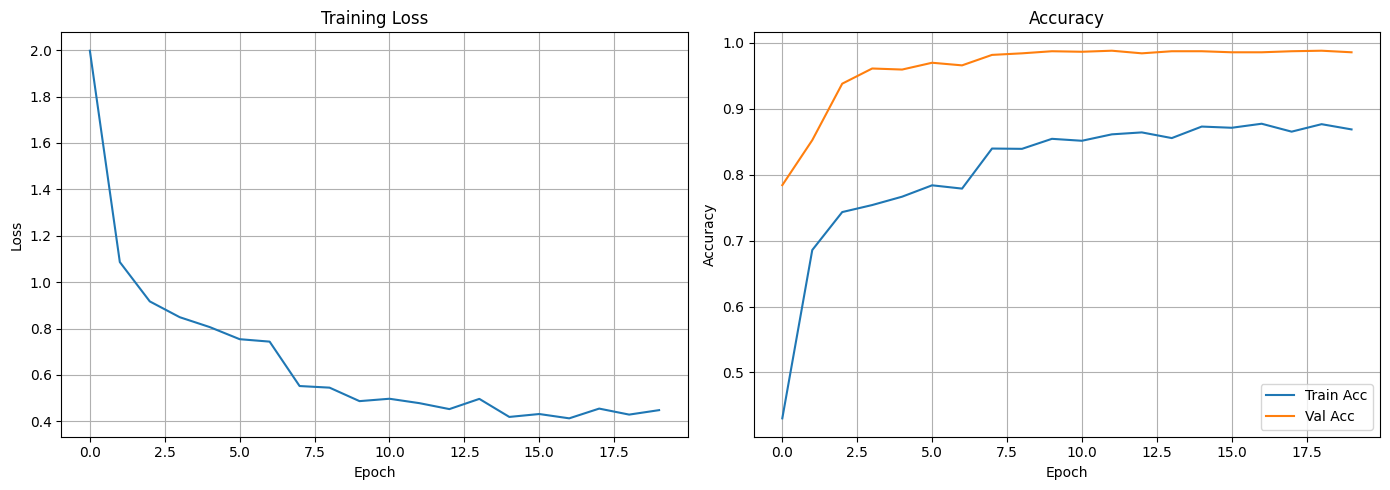

📊 Saved training plot as 'training_history.png'


Evaluating: 100%|██████████| 158/158 [00:43<00:00,  3.65it/s]



📊 Validation Accuracy: 0.9881

Classification Report:
              precision    recall  f1-score   support

   Beautiful       1.00      1.00      1.00        28
        Come       1.00      0.99      0.99        84
       Drink       1.00      1.00      1.00        28
         Eat       0.82      1.00      0.90        28
   Fine_Okay       1.00      0.86      0.92        42
      Friend       1.00      1.00      1.00        63
          Go       1.00      1.00      1.00        49
        Good       0.90      1.00      0.95        56
       Happy       1.00      1.00      1.00        35
 He_She_They       1.00      0.93      0.96        28
    Hello_Hi       1.00      1.00      1.00        42
        Help       1.00      0.86      0.92        42
         How       1.00      1.00      1.00        35
      Hungry       1.00      1.00      1.00        56
        I_Me       1.00      1.00      1.00        49
        Like       1.00      1.00      1.00        28
        Love       1.00   

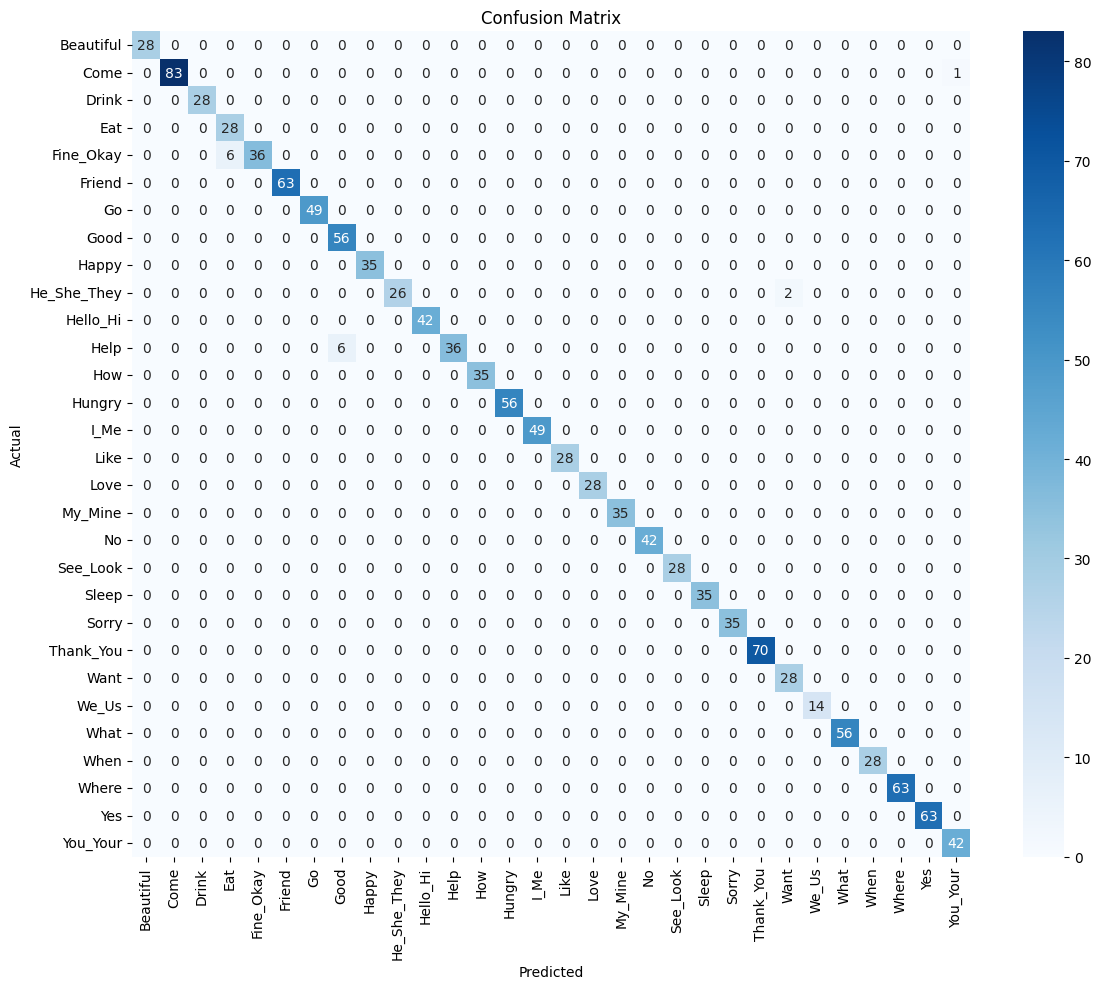

📊 Saved confusion matrix as 'confusion_matrix.png'


In [2]:
def main():
    data_dir = r"isl_inverted"
    model_path = "best_efficientnetb0_model.pth"

    classifier = EfficientNetB0ISLClassifier(data_dir)
    classifier.train(num_epochs=20, learning_rate=0.001, save_path=model_path)
    classifier.evaluate(model_path=model_path)

if __name__ == "__main__":
    print("📦 Make sure the following are installed:")
    print("pip install torch torchvision scikit-learn matplotlib seaborn tqdm")
    main()



# Test 

In [22]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Speed boost for fixed input sizes
print(f"Running on device: {device}")


Running on device: cuda


In [23]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Modify the classifier for your number of classes
num_classes = 30
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)

# Load checkpoint
checkpoint = torch.load("best_efficientnetb0_model.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device).eval()


c:\Users\Owner\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Owner\anaconda3\envs\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:

class_names = checkpoint.get("class_names", [f"Class_{i}" for i in range(num_classes)])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils


In [25]:

def predict_hand(frame):
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        h, w, _ = frame.shape
        x_min, y_min, x_max, y_max = w, h, 0, 0

        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min = min(x, x_min)
                y_min = min(y, y_min)
                x_max = max(x, x_max)
                y_max = max(y, y_max)

        
        pad = 30
        x_min = max(x_min - pad, 0)
        y_min = max(y_min - pad, 0)
        x_max = min(x_max + pad, w)
        y_max = min(y_max + pad, h)

        cropped_hand = frame[y_min:y_max, x_min:x_max]

        if cropped_hand.size == 0 or (x_max - x_min < 20 or y_max - y_min < 20):
            return None, 0.0

        pil_img = Image.fromarray(cv2.cvtColor(cropped_hand, cv2.COLOR_BGR2RGB))
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                outputs = model(input_tensor)
                probs = torch.nn.functional.softmax(outputs[0], dim=0)
                pred_index = torch.argmax(probs).item()
                confidence = probs[pred_index].item()

        return class_names[pred_index], confidence

    return None, 0.0


# on cam 


In [26]:

cap = cv2.VideoCapture(0)
print("✅ Webcam started. Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    pred_class, confidence = predict_hand(frame)

    if pred_class:
        text = f"{pred_class} ({confidence * 100:.1f}%)"
        color = (0, 255, 0)
    else:
        text = "No hand detected"
        color = (0, 0, 255)

    cv2.putText(frame, text, (10, 35), cv2.FONT_HERSHEY_SIMPLEX,
                1, color, 2, cv2.LINE_AA)

    cv2.imshow("ISL Real-Time", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


✅ Webcam started. Press 'q' to quit.


C:\Users\Owner\AppData\Local\Temp\ipykernel_1624\3634501321.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
